# About

This notebook runs XGBoost to produce Stage 1 and Stage 2 results for a specified instrument, lag/lead, health outcome, and fixed effects combination.

XGBoost models were hyperparameter tuned using 5 fold time series cross validation (expanding window). 
- The best parameters were used to train a full model on the 2002-2017 datasets. 
- Held out performance is best assessed from the CV split, since we don't have access to 2018 data for PM2.5 or health.

The 2nd stage regression predicts the medical outcomes using the predicted PM2.5, as well as the same fixed effects from the first stage regression.

The 2nd stage model is used to make counterfactual predicted health outcomes if we reduced air pollution (predicted PM2.5)  by 1%, 10%, and 25%.

---
Running this notebook requires the following file structure changes:
- Just as in the OLS notebooks, please make sure the modeling data is in `'C:/Users/cilin/Research/CA_hospitals_capstone/data/'` and the medical data is in `'C:/Users/cilin/Research/CA_hospitals_capstone/output/'`. Please make sure these are named the same as when you ran the OLS notebooks.
- Add a new directory or make sure this one exists: `out_dir_xgb = 'C:/Users/cilin/Research/CA_hospitals_capstone/xgb/'`

Please also ensure that you have the `xgboost` package in your Python interpreter. If using conda, you can install xgboost
- This notebook uses the sklearn api for xgboost: `xgb.XGBRegressor()`
- https://github.com/dmlc/xgboost
- Installation Page: https://xgboost.readthedocs.io/en/stable/install.html

In [101]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

Combinations of Instruments and Fixed Effects here:
https://docs.google.com/spreadsheets/d/1_MMYeQuxiov2OLE5AX0CE9R1T1mBrk7vpozy2fGjNBg/edit#gid=0 

Instruments:

- `Izmy_v3_normed_D_and_TPY`
- `Izmy_v4_nodist_normed_TPY`
- `Izmy_v5_all_normed_but_wspd_ratio`
- `Izmy_v7_all_normed_no_wspd`


We will use lead and lag of 9 months and 3 months respectively.

For fixed effects, we choose from a set of 9 possible combinations outlined here:

- https://docs.google.com/spreadsheets/d/1_MMYeQuxiov2OLE5AX0CE9R1T1mBrk7vpozy2fGjNBg/edit#gid=0

In [102]:
# set instrumental variable version
##  Predictor options:
# - `Izmy_v3_normed_D_and_TPY`
# - `Izmy_v4_nodist_normed_TPY`
# - `Izmy_v5_all_normed_but_wspd_ratio`

predictor = 'Izmy_v4_nodist_normed_TPY'

# set FE to one of 4 sets (int)
FE_set_num = 7

# specify medical target
medical_target = 'y_visits_hematopoietic_cancers_fwd3' # select the name just as it is in 2sls 2nd stage output notebook

# If we want to filter outliers on the medical outcome
filter_medical_outliers = True

# sets unique notebooks index (string)
notebook_index = "16"



In [103]:
lead_time = '9'
lag_time = '3'
lag_style = 'fwd'

# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag 
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col # columns to filter out at the beginning and end of df, before modeling

target_name_s1 = f'pm25{IV_lead_input}'
predictor_name_s1 = f'{predictor}{IV_lead_input}'

print(f"Stage 1\nTarget Name (target_name_s1) = {target_name_s1}\nPredictor Name (predictor_name_s1) = {predictor_name_s1}")

print(f"\nStage 2\nHealth Outcome Lag Input (HO_lag_input) = {HO_lag_input}")
print(f"Medical Health Outcome Target: {medical_target}")
print(f"Predictor Name: {target_name_s1 + '_hat'}")


Stage 1
Target Name (target_name_s1) = pm25_r9
Predictor Name (predictor_name_s1) = Izmy_v4_nodist_normed_TPY_r9

Stage 2
Health Outcome Lag Input (HO_lag_input) = _fwd3
Medical Health Outcome Target: y_visits_hematopoietic_cancers_fwd3
Predictor Name: pm25_r9_hat


# Set Path

Add a new elif section for your path if you want

In [104]:
# local or gdrive
path_source = 'msl'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

elif path_source == 'local_anand':

  # in Anand's computer
  in_dir_sc = 'C:/Users/anandadmin/MIDS/210 Capstone/data/'
  in_dir_h = 'C:/Users/anandadmin/MIDS/210 Capstone/output/'
  out_dir1 = 'C:/Users/anandadmin/MIDS/210 Capstone/models_s1/'
  out_dir2 = 'C:/Users/anandadmin/MIDS/210 Capstone/models_s2/'
  # folder containing csvs documenting which fixed effects are in which csv files
  out_dir3 = 'C:/Users/anandadmin/MIDS/210 Capstone/fixed_effects/'  
  # folder to store XGB model and output csv files
  out_dir_xgb = 'G:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\W210_Capstone\\fitted_models\\2022-11-19\\XGB'

elif path_source == 'local_cornelia':
  in_dir_sc = 'C:/Users/cilin/Research/CA_hospitals_capstone/data/'
  in_dir_h = 'C:/Users/cilin/Research/CA_hospitals_capstone/output/'
  # folder containing stage 1 outputs
  out_dir1 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s1/'
  # folder containing stage 2 outputs
  out_dir2 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s2/'
  # folder containing csvs documenting which fixed effects are in which csv files
  out_dir3 = 'C:/Users/cilin/Research/CA_hospitals_capstone/fixed_effects/'
  # folder to store XGB model and output csv files
  out_dir_xgb = 'C:/Users/cilin/Research/CA_hospitals_capstone/xgb/'

elif path_source == 'msl':
  in_dir_sc = 'C:/Users/matts/Documents/Berkeley MIDS/DataSci 210 Capstone/non-push files/data/'
  in_dir_h = in_dir_sc + 'output/'
  # folder containing stage 1 outputs
  out_dir1 = in_dir_sc + 'models_s1/'
  # folder containing stage 2 outputs
  out_dir2 = in_dir_sc + 'models_s2/'
  # folder containing csvs documenting which fixed effects are in which csv files
  out_dir3 = in_dir_sc + 'fixed_effects/'
  # folder to store XGB model and output csv files
  out_dir_xgb = in_dir_sc + 'xgb/'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

In [105]:
# non-medical data
for file in os.listdir(in_dir_sc):
    if file.startswith('modeling'):
        # read in our modeling data
        df = pd.read_csv(os.path.join(in_dir_sc, file))

# add key to df
df['patzip_year_month'] = df.school_zip.astype(str) + '-' + df.year.astype(str) + '-' + df.month.astype(str)

display(df.head(1))

,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.272222,0.011111,90001-2000-1


In [106]:
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])


# Data Clean

Non Med Data

In [107]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed'
    ,'Izmy_v6_unnormed_no_wspd'
    ,'Izmy_v7_all_normed_no_wspd'
    ,'Izmy_v8_normed_D_and_TPY_no_wspd'
    ,'new_alignment_90_high'
    ,'avg_temp']
    ,rolling_periods:list = [1, 6, 9, 12]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month']).reset_index(drop=True)
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = [1, 6, 9, 12]

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int


cols_to_roll = [predictor
    ,'avg_wspd_top_15'
    ,'avg_temp'
    ,'diff_temp_s_ps']

rolling_periods = [int(lead_time)]

df, all_cols = roll_selected_cols(df=df, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

# rename the last month column just to be consistent and safe
df.rename(columns={'pm25_last_month': 'pm25_r1'}, inplace=True)

# drop if year >=2018
df = df[df.year.le(2017)]

# print shape of data
print('Shape of our schools modeling data ', df.shape)
df.head(2)

Shape of our schools modeling data  (294897, 164)


,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_r1,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,avg_wspd_top_15_r1,avg_wspd_top_15_r6,avg_wspd_top_15_r9,avg_wspd_top_15_r12,avg_temp_r1,avg_temp_r6,avg_temp_r9,avg_temp_r12,diff_temp_s_ps_r1,diff_temp_s_ps_r6,diff_temp_s_ps_r9,diff_temp_s_ps_r12
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.272222,0.011111,90001-2000-1,NaN,N

Med data

In [108]:
# medical data
df_med = pd.DataFrame()
df_med['patzip_year_month'] = df.patzip_year_month.unique()

for file in os.listdir(in_dir_h):
    # read in cornelia's healthcare data
    temp = pd.read_csv(os.path.join(in_dir_h, file)).iloc[:,1:]
    # rename number_of_visits column
    temp.rename(
        columns={'number_of_visits':'visits_'+file.split('.')[0]},
        inplace=True
    )

    # merge to df_med
    df_med = df_med.merge(
        temp[['patzip_year_month', 'visits_'+file.split('.')[0]]],
        on='patzip_year_month',
        how='left'
    )

# Filter out 2018 data bc it's all nulls 
# if year > 2017, drop
df_med['year_h'] = df_med.patzip_year_month.str.split('-').str[1]
df_med = df_med[df_med.year_h.le('2017')]
df_med.drop(columns='year_h', inplace=True)

# print shape of data
print('Shape of medical data ', df_med.shape)
df_med[~df_med.iloc[:, -1].isna()].head(2)

Shape of medical data  (294897, 6)


,patzip_year_month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes
36008,91214-2008-12,NaN,129.0,NaN,121.0,17.0
36070,91214-2014-2,NaN,120.0,NaN,125.0,17.0


In [109]:
df_med.columns

Index(['patzip_year_month', 'visits_hematopoietic_cancers',
       'visits_injuries_accidents', 'visits_pediatric_vasculitis',
       'visits_resp_cardio', 'visits_type_1_diabetes'],
      dtype='object')

Dynamically add 'y_' and lag times to the column names

In [110]:
# Get the list of outcome columns from the merged health dataset (df_med above)
num_visits_col_names = [i for i in list(df_med.columns) if 'visit' in i]
print("num_visits_col_names:\n{}\n".format(num_visits_col_names))

# y_col_names is used in Section 5.4.
y_col_names = ['y_' + i for i in num_visits_col_names]
print("y_col_names:\n{}\n".format(y_col_names))

# create a list of columns for outcome variables with health outcome lag window added
# y_col_names_lag is used in Step 7
y_col_names_lag = []
for i in y_col_names:
    new_name = i + HO_lag_input
    y_col_names_lag.append(new_name)

print("y_col_names_lag:\n{}".format(y_col_names_lag))

# create a list of columns for outcome variables with health outcome lag window added
# y_col_names_lag is used in Step 7
y_col_names_lag_diff = []
for i in y_col_names_lag:
    new_name = i + '_diff_r12'
    y_col_names_lag_diff.append(new_name)

print("\ny_col_names_lag_diff:\n{}".format(y_col_names_lag_diff))

num_visits_col_names:
['visits_hematopoietic_cancers', 'visits_injuries_accidents', 'visits_pediatric_vasculitis', 'visits_resp_cardio', 'visits_type_1_diabetes']

y_col_names:
['y_visits_hematopoietic_cancers', 'y_visits_injuries_accidents', 'y_visits_pediatric_vasculitis', 'y_visits_resp_cardio', 'y_visits_type_1_diabetes']

y_col_names_lag:
['y_visits_hematopoietic_cancers_fwd3', 'y_visits_injuries_accidents_fwd3', 'y_visits_pediatric_vasculitis_fwd3', 'y_visits_resp_cardio_fwd3', 'y_visits_type_1_diabetes_fwd3']

y_col_names_lag_diff:
['y_visits_hematopoietic_cancers_fwd3_diff_r12', 'y_visits_injuries_accidents_fwd3_diff_r12', 'y_visits_pediatric_vasculitis_fwd3_diff_r12', 'y_visits_resp_cardio_fwd3_diff_r12', 'y_visits_type_1_diabetes_fwd3_diff_r12']


Merge non-medical and medical datasets

In [111]:
if isinstance(df.year_month[0], str):
  # if year month is still a string, convert it to datetime
  # don't try if already converted
    df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

# merge df_h to df_sc
df = df.merge(
    df_med,
    on='patzip_year_month',
    how='left'
)


# print shape of data
print('Shape of data ', df.shape)
df.head(2)

Shape of data  (294897, 169)


,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_r1,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,avg_wspd_top_15_r1,avg_wspd_top_15_r6,avg_wspd_top_15_r9,avg_wspd_top_15_r12,avg_temp_r1,avg_temp_r6,avg_temp_r9,avg_temp_r12,diff_temp_s_ps_r1,diff_temp_s_ps_r6,diff_temp_s_ps_r9,diff_temp_s_ps_r12,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,

#### Fill in nulls conditionally on merged datasets

* For each health outcome, fill in the nulls for a zipcode with 0's ONLY if that row occurred after the first non-zero/not-null visit in that zipcode for that health outcome (keeps them as nulls otherwise)

In [112]:
def filter_nans(df, visits_cols = ['visits_hematopoietic_cancers', 'visits_injuries_accidents',
       'visits_type_1_diabetes', 'visits_pediatric_vasculitis',
       'visits_resp_cardio']):
    """Function to generate columns in place that replace NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # check the school zip first
        if dataset_row_idx < first_val_row_idx:
            orig_visits = orig_visits
        elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
            if pd.isnull(orig_visits):
                orig_visits = 0
            else:
                orig_visits = orig_visits
        return orig_visits
        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    #df_grouped_schools['points_rank'] = df.groupby(['team'])['points'].rank('dense', ascending=False)
    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]
            #display(temp)
            #temp['rowIndex'] = temp.apply(get_rowIndex, axis=1)
            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            #display(visits_series)
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set valye to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

In [113]:
# call function:
df.sort_values(['school_zip', 'year_month'], inplace=True)
df = filter_nans(df, visits_cols = num_visits_col_names)
print('Shape of data ', df.shape)
display(df)

Shape of data  (294897, 169)


,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_r1,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,avg_wspd_top_15_r1,avg_wspd_top_15_r6,avg_wspd_top_15_r9,avg_wspd_top_15_r12,avg_temp_r1,avg_temp_r6,avg_temp_r9,avg_temp_r12,diff_temp_s_ps_r1,diff_temp_s_ps_r6,diff_temp_s_ps_r9,diff_temp_s_ps_r12,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2.608176e+06,47.873130,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

Create response variables

In [114]:
# Create response variables, which is visits / population
for col in num_visits_col_names:
    df['y_'+col] = 1000 * df[col] / df['total_pop_under19']
    
# add year trend
year_map = {label: idx for idx, label in enumerate(np.sort(df.year.unique()))}
df["year_trend"] = df.year.map(year_map)
df["year_trend"] = df.year_trend + 1

# fixing month datatype
df['month'] = df['month'].astype(str)

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county (in case we want to just direclty use this var for the interaction effects)
df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

# reset index
df.reset_index(drop=True, inplace=True)

# print shape of data
print('Shape of data ', df.shape) # Old shape of data  (294897, 174)
df.head(2)

Shape of data  (294897, 177)


,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_r1,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,avg_wspd_top_15_r1,avg_wspd_top_15_r6,avg_wspd_top_15_r9,avg_wspd_top_15_r12,avg_temp_r1,avg_temp_r6,avg_temp_r9,avg_temp_r12,diff_temp_s_ps_r1,diff_temp_s_ps_r6,diff_temp_s_ps_r9,diff_temp_s_ps_r12,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_pediatric_vasculitis,y_visits_resp_cardio,y_visits_type_1_diabetes,year_trend,county_month,year_month_county
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,Na

### Make Rolling HO Sum Columns

In [115]:
# sort data on date
df = df.sort_values('year_month').reset_index(drop=True)

# train/test split 
# keep 2018 as the held out test set
df_test = df[df.year == 2018]
df = df[df.year != 2018]    # filter out 2018 from our dataset

In [116]:
# get rolling n month sum
def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month']).reset_index(drop=True)
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 


df = df.sort_values(['school_zip', 'year_month'])
starting_cols = list(df.columns)

# 3 months ---
n = int(lag_time) # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df[f'{health_outcome_visits_col}_fwd{n}'] / df['total_pop_under19']

    # centered columns
    df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df[f'{health_outcome_y_col}_cent{n}'] = 1000 * df[f'{health_outcome_visits_col}_cent{n}'] / df['total_pop_under19']


# print columns added
ending_cols = list(df.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using {n} month window:\n{window_3months_columns}")
starting_cols = list(df.columns)


# # filter data to appropriate data range
# df = df[df.year >= 2002]


Columns added for health outcomes using 3 month window:
['visits_hematopoietic_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'visits_hematopoietic_cancers_cent3', 'y_visits_hematopoietic_cancers_cent3', 'visits_injuries_accidents_fwd3', 'y_visits_injuries_accidents_fwd3', 'visits_injuries_accidents_cent3', 'y_visits_injuries_accidents_cent3', 'visits_pediatric_vasculitis_fwd3', 'y_visits_pediatric_vasculitis_fwd3', 'visits_pediatric_vasculitis_cent3', 'y_visits_pediatric_vasculitis_cent3', 'visits_resp_cardio_fwd3', 'y_visits_resp_cardio_fwd3', 'visits_resp_cardio_cent3', 'y_visits_resp_cardio_cent3', 'visits_type_1_diabetes_fwd3', 'y_visits_type_1_diabetes_fwd3', 'visits_type_1_diabetes_cent3', 'y_visits_type_1_diabetes_cent3']


Make the 12 month difference between health outcome columns

In [117]:
def y_outcome_difference_maker(df, y_variable_col_name, num_months_back):

  '''
  This function takes the 12 month difference of the health outcome. 

  We would use it after we make our y_visits_ columns in Cornelia's notebook on those columns. In stage 2, we use these columns as our y variable. 

  Fix Cornelia's 2sls script notebooks to use the y_visits that are there originally and then run and OLS on this difference column for it right underneath.
  '''
  df_copy = df.copy().sort_values(['school_zip', 'year_month']).reset_index(drop=True)

  df_copy[f'{y_variable_col_name}_diff_r{num_months_back}'] = df_copy.groupby('school_zip')[y_variable_col_name]\
                                        .apply(lambda x:x - x.shift(num_months_back))

  print(f"Outcome generated: {y_variable_col_name}_diff_r{num_months_back}")
  return df_copy


In [118]:
# add the 12 month differences for the health outcomes
for var_name in y_col_names_lag:
    df = y_outcome_difference_maker(df, var_name, 12)

display(df)

Outcome generated: y_visits_hematopoietic_cancers_fwd3_diff_r12
Outcome generated: y_visits_injuries_accidents_fwd3_diff_r12
Outcome generated: y_visits_pediatric_vasculitis_fwd3_diff_r12
Outcome generated: y_visits_resp_cardio_fwd3_diff_r12
Outcome generated: y_visits_type_1_diabetes_fwd3_diff_r12


,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_r1,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,avg_wspd_top_15_r1,avg_wspd_top_15_r6,avg_wspd_top_15_r9,avg_wspd_top_15_r12,avg_temp_r1,avg_temp_r6,avg_temp_r9,avg_temp_r12,diff_temp_s_ps_r1,diff_temp_s_ps_r6,diff_temp_s_ps_r9,diff_temp_s_ps_r12,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_pediatric_vasculitis,y_visits_resp_cardio,y_visits_type_1_diabetes,year_trend,county_month,year_month_county,visits_hematopoietic_cancers_fwd3,y_visits_hematopoietic_cancers_fwd3,visits_hematopoietic_cancers_cent3,y_visits_hematopoietic_cancers_cent3,visits_injuries_accidents_fwd3,y_visits_injuries_accidents_fwd3,visits_injuries_accidents_cent3,y_visits_injuries_accidents_cent3,visits_pediatric_vasculitis_fwd3,y_visits_pediatric_vasculitis_fwd3,visits_pediatric_vasculitis_cent3,y_visits_pediatr

Show General Statistics and Outliers

In [119]:
# for our y variable: y_col_names_lag
for i in y_col_names_lag:
    print(f"Outcome: {i}")
    display(df[i].describe())

    # df_temp_print = df[ np.abs(df[i]-df[i].mean()) <= min(3*df[i].std(), 1000*int(lag_time)) ]
    df_temp_print = df[ np.abs(df[i]-df[i].mean()) <= (3*df[i].std()) ]
    j = df[~df[i].isna()].shape[0]-df_temp_print[~df_temp_print[i].isna()].shape[0]
    print(f"If outliers (over 3 std away) were filtered out we lose {j} rows:")
    display(df_temp_print[i].describe())
    print("\n----\n")

Outcome: y_visits_hematopoietic_cancers_fwd3


count    66363.000000
mean         1.690923
std          8.353952
min          0.000000
25%          0.000000
50%          0.000000
75%          1.679012
max        652.841782
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 527 rows:


count    65836.000000
mean         1.175206
std          2.544887
min          0.000000
25%          0.000000
50%          0.000000
75%          1.635401
max         26.678929
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64


----

Outcome: y_visits_injuries_accidents_fwd3


count    134888.000000
mean        242.616329
std        1261.826569
min           0.000000
25%          25.053036
50%          49.039777
75%         178.200795
max      112000.000000
Name: y_visits_injuries_accidents_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 948 rows:


count    133940.000000
mean        186.533316
std         353.011005
min           0.000000
25%          24.882900
50%          48.642248
75%         171.210572
max        3240.740741
Name: y_visits_injuries_accidents_fwd3, dtype: float64


----

Outcome: y_visits_pediatric_vasculitis_fwd3


count    93064.000000
mean         0.917828
std          3.666329
min          0.000000
25%          0.000000
50%          0.000000
75%          1.096067
max        310.017095
Name: y_visits_pediatric_vasculitis_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 756 rows:


count    92308.000000
mean         0.696623
std          1.429485
min          0.000000
25%          0.000000
50%          0.000000
75%          1.046776
max         11.908198
Name: y_visits_pediatric_vasculitis_fwd3, dtype: float64


----

Outcome: y_visits_resp_cardio_fwd3


count    147106.000000
mean        226.125416
std        1177.493193
min           0.000000
25%          27.695648
50%          51.080057
75%         160.132263
max      112000.000000
Name: y_visits_resp_cardio_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 907 rows:


count    146199.000000
mean        174.900889
std         333.785376
min           0.000000
25%          27.572982
50%          50.711744
75%         155.309561
max        3219.824922
Name: y_visits_resp_cardio_fwd3, dtype: float64


----

Outcome: y_visits_type_1_diabetes_fwd3


count    65096.000000
mean         1.175000
std         18.508886
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2012.072435
Name: y_visits_type_1_diabetes_fwd3, dtype: float64

If outliers (over 3 std away) were filtered out we lose 97 rows:


count    64999.000000
mean         0.837701
std          3.161133
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.999157
Name: y_visits_type_1_diabetes_fwd3, dtype: float64


----



In [120]:
# for 12 month difference columns: y_col_names_lag_diff
for i in y_col_names_lag_diff:
    print(f"Outcome: {i}")
    display(df[i].describe())

    # df_temp_print = df[ np.abs(df[i]-df[i].mean()) <= min(3*df[i].std(), 1000*int(lag_time)) ]
    df_temp_print = df[ np.abs(df[i]-df[i].mean()) <= (3*df[i].std()) ]
    j = df[~df[i].isna()].shape[0]-df_temp_print[~df_temp_print[i].isna()].shape[0]
    print(f"If outliers (over 3 std away) were filtered out we lose {j} rows:")
    display(df_temp_print[i].describe())
    print("\n----\n")

Outcome: y_visits_hematopoietic_cancers_fwd3_diff_r12


count    59928.000000
mean        -0.392439
std          8.478895
min       -652.841782
25%         -0.080734
50%          0.000000
75%          0.021771
max        245.806825
Name: y_visits_hematopoietic_cancers_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 657 rows:


count    59271.000000
mean        -0.107615
std          2.925823
min        -25.819033
25%         -0.057476
50%          0.000000
75%          0.019596
max         25.000000
Name: y_visits_hematopoietic_cancers_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_injuries_accidents_fwd3_diff_r12


count    125984.000000
mean         28.917158
std        1410.899260
min     -112000.000000
25%          -1.189393
50%           0.802742
75%           6.548772
max      112000.000000
Name: y_visits_injuries_accidents_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 974 rows:


count    125010.000000
mean         13.131828
std         307.596548
min       -2971.076291
25%          -1.166759
50%           0.797226
75%           6.343576
max        3024.901421
Name: y_visits_injuries_accidents_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_pediatric_vasculitis_fwd3_diff_r12


count    85945.000000
mean        -0.029637
std          4.478535
min       -310.017095
25%          0.000000
50%          0.000000
75%          0.000000
max        174.339478
Name: y_visits_pediatric_vasculitis_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 901 rows:


count    85044.000000
mean         0.028912
std          2.027662
min        -13.449367
25%          0.000000
50%          0.000000
75%          0.000000
max         13.335655
Name: y_visits_pediatric_vasculitis_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_resp_cardio_fwd3_diff_r12


count    138202.000000
mean         17.160002
std        1207.875646
min     -112000.000000
25%          -2.029509
50%           0.475988
75%           7.186268
max       75000.000000
Name: y_visits_resp_cardio_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 943 rows:


count    137259.000000
mean         12.939834
std         299.986988
min       -2973.684211
25%          -1.995838
50%           0.473099
75%           7.050290
max        3011.533252
Name: y_visits_resp_cardio_fwd3_diff_r12, dtype: float64


----

Outcome: y_visits_type_1_diabetes_fwd3_diff_r12


count    58082.000000
mean        -0.043293
std         18.122993
min      -2012.072435
25%          0.000000
50%          0.000000
75%          0.000000
max        326.923077
Name: y_visits_type_1_diabetes_fwd3_diff_r12, dtype: float64

If outliers (over 3 std away) were filtered out we lose 133 rows:


count    57949.000000
mean         0.124696
std          3.705210
min        -53.564227
25%          0.000000
50%          0.000000
75%          0.000000
max         53.178178
Name: y_visits_type_1_diabetes_fwd3_diff_r12, dtype: float64


----



Prepare Data for Modeling

In [121]:
# filter data to appropriate data range
df = df[df.year >= 2002]

print(min(df.year))
print(max(df.year))

2002
2017


In [122]:
# Select variables for modeling
date_var = 'year_month' 
zip_var = 'school_zip'
y_var_s2 = medical_target   # need to change this so it runs on Cornelia's PC
print(f"medical target: {y_var_s2}")

# stage 1 variables
instruments_cols = [predictor]

stage_1_IVs = [s + IV_lead_input for s in instruments_cols]
stage_1_target = [target_name_s1]

# stage 2 variables
stage_2_HO_targets = [s + HO_lag_input for s in y_col_names]

num_vars = ['school_elevation_m', 'nearby_point_source_count', 'school_wspd', \
            'tax_liability_per_capita', 'school_temperature', 'school_count', 'pm25_r6', 'pm25_r12']
counties = [i for i in df.columns if re.search('^school_county_v2_', i)]
months = [i for i in df.columns if re.search ('^month_', i)]
# potentially use county_month instead of the above 

xvars = num_vars + counties + months 
yvar = [y_var_s2]

medical target: y_visits_hematopoietic_cancers_fwd3


# xgb stage 1

Setups

In [123]:
basics = counties + months + ['year_trend']
env = ['avg_temp'+IV_lead_input , 'avg_elevation_diff_m']

if FE_set_num == 1:
    # FE Set 1
    adds = []
elif FE_set_num == 2:
    # FE Set 2
    adds = ['ca_agi_per_returns', 'total_population']
elif FE_set_num == 3:
    # FE Set 3
    adds = ['school_count', 'total_population']
elif FE_set_num == 4:
    # FE Set 4
    adds = ['total_population', 'avg_count_ps_within_5km']
elif FE_set_num == 5:
    # FE Set 5
    adds = ['ca_agi_per_returns']
elif FE_set_num == 6:
    # FE Set 6
    adds = ['total_population']
elif FE_set_num == 7:
    # FE Set 7
    adds = ['ca_agi_per_returns', 'total_population', 'avg_wspd_top_15_r' + str(lead_time)]
elif FE_set_num == 8:
    env = []
    adds = []
elif FE_set_num == 9:
    # FE Set 9
    adds = ['avg_wspd_top_15_r' + str(lead_time)]
    env = []




fixed_effects_cols = basics + env + adds

print("basics:\n{}\n".format(basics))
print("env:\n{}\n".format(env))

print("Fixed effects are:\n{}".format(fixed_effects_cols))

basics:
['school_county_v2_alameda', 'school_county_v2_alpine', 'school_county_v2_amador', 'school_county_v2_butte', 'school_county_v2_calaveras', 'school_county_v2_colusa', 'school_county_v2_contra_costa', 'school_county_v2_del_norte', 'school_county_v2_el_dorado', 'school_county_v2_fresno', 'school_county_v2_glenn', 'school_county_v2_humboldt', 'school_county_v2_imperial', 'school_county_v2_inyo', 'school_county_v2_kern', 'school_county_v2_kings', 'school_county_v2_lake', 'school_county_v2_lassen', 'school_county_v2_los_angeles', 'school_county_v2_madera', 'school_county_v2_marin', 'school_county_v2_mariposa', 'school_county_v2_mendocino', 'school_county_v2_merced', 'school_county_v2_modoc', 'school_county_v2_mono', 'school_county_v2_monterey', 'school_county_v2_napa', 'school_county_v2_nevada', 'school_county_v2_orange', 'school_county_v2_placer', 'school_county_v2_plumas', 'school_county_v2_riverside', 'school_county_v2_sacramento', 'school_county_v2_san_benito', 'school_county_v2_

In [124]:
# check if all these columns are in the dataframe
in_col_list = [True if i in df.columns else i for i in fixed_effects_cols ]

print(f"These should be all true if all fixed effects are in df.columns:\n{in_col_list}")

print(f"\nStage 1 Variables---\n")
print(f"target_name_s1: {target_name_s1}\nIn df columns? {target_name_s1 in df.columns}\n")
print(f"predictor_name_s1: {predictor_name_s1}\nIn df columns? {predictor_name_s1 in df.columns}\n")

print(f"Fixed Effects (fixed_effects_cols): {fixed_effects_cols}\n")

target_name_s1_predictions = target_name_s1 + "_hat"
print(f"Saving predictions (target_name_s1_predictions) as `{target_name_s1_predictions}`")

# create a df for modeling stage 1: drops nulls in all columns used
df_model_s1 = df.dropna(subset=([target_name_s1, predictor_name_s1] + fixed_effects_cols))

print(f"Size of df before filtering for modeling: {df.shape}")
print(f"Size of df after filtering for modeling: {df_model_s1.shape}")


X_s1 = df_model_s1[[predictor_name_s1] + fixed_effects_cols]
y_s1 = df_model_s1[target_name_s1]



These should be all true if all fixed effects are in df.columns:
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]

Stage 1 Variables---

target_name_s1: pm25_r9
In df columns? True

predictor_name_s1: Izmy_v4_nodist_normed_TPY_r9
In df columns? True

Fixed Effects (fixed_effects_cols): ['school_county_v2_alameda', 'school_county_v2_alpine', 'school_county_v2_amador', 'school_county_v2_butte', 'school_county_v2_calaveras', 'school_county_v2_colusa', 'school_county_v2_contra_costa', 'school_county_v2_del_norte', 'school_county_v2_el_dorado', 'school_county_v2_fresno', 'school_county_v2_g

In [125]:
# need to sort the values and use the index to sort things for TimeSeriesSplit
df_model_s1.sort_values(by=['year_month'], inplace=True)
df_model_s1 = df_model_s1.reset_index(drop=True)

In [126]:
# sklearn api version
def time_series_cv(
  df: pd.DataFrame, 
  xvars: list, 
  yvar: str, 
  hyperparams: dict = {'max_depth': [1, 5, 10], 'subsample': [.8, 1], 'eta': [.1, .3]}, 
  search_type='grid', 
  folds=5, 
  verbose=1):

  ''' 
  Inputs:
  - df: dataframe of your training data
  - xvars: a list of all the xvars to pass to xgboost
  - yvar: string of your target variable
  - verbose: optionality for diff amounts of printouts. Can be 0, 1, 2. 0 = silent, 1 = update after each fold, 2 = update after every single hyperparam combination. 
  - hyperparams: this must be a dictionary of lists. So each key is a xgb hyperparam, then it must have a list of values to tune with. 
    See the default for an example. Can put in an arbitrary number of hyperparam options. 
  
  Output:
  - dictionary with the following keys: ['fold', 'hyperparams', 'rmse_train', 'rmse_test']. 
  eval(best_hyperparams)
  - dictionary with the best hyperparameters to retrain model
  '''

  # need to sort the values and use the index to sort things
  df.sort_values(by=['year_month'], inplace=True)
  df = df.reset_index(drop=True)

  # this dictionary will hold all the final results
  final_res = {'fold':[], 'hyperparams':[], 'rmse_train': [], 'rmse_test': [],
                'huber_loss_train': [], 'huber_loss_test': []}

  # get only necessary fields in df
  df = df[xvars + [yvar]]

  # set up the time series split class, to do an expanding window cross fold. 
  tss = TimeSeriesSplit(n_splits=folds)
  tss_folds = tss.split(df)
  all_folds = [i for i in tss_folds]

  # get all combinations of hyperparams
  def expand_grid(hyperparams):
    keys = list(hyperparams.keys())
    hyperparams_df = pd.DataFrame(np.array(np.meshgrid(*[hyperparams[key_i] for key_i in keys])).T.reshape(-1, len(keys)))
    hyperparams_df.columns = keys 
    return hyperparams_df

  df_hyperparams = expand_grid(hyperparams)

  # loss functions
  def get_rmse(df_train, model):
    ytrue = df_train[yvar].values.flatten()
    yhat = model.predict(df_train.drop(columns=yvar))
    rmse = np.mean(((ytrue - yhat)**2)**.5)
    return rmse 
  
  def get_huber_loss(df_train, model):
    # # Let the delta for Huber Loss be 2*standard deviation of non-zero entries for the y variable
    # twice_std = 2 * df_train[df_train[yvar] > 0][yvar].std  

    # Let the delta for Huber Loss be 2*standard deviation of the y variable
    twice_std = 2 * df_train[yvar].std() 

    def huber_loss(y_actual,y_predicted,delta):
      # https://towardsdatascience.com/understanding-loss-functions-the-smart-way-904266e9393
      # approaches MSE for small error an approaches MAE in case of outliers.
      delta = 5
      total_points = y_actual.size
      total_error = 0
      for i in range(total_points):
        error = np.absolute(y_predicted[i] - y_actual[i])
        if error < delta:
          huber_error = (error*error)/2
        else:
          huber_error = delta*(error - (0.5*delta))
        total_error+=huber_error
      total_huber_error = total_error/total_points
      return total_huber_error  # mean huber_loss

    ytrue = df_train[yvar].values.flatten()
    yhat = model.predict(df_train.drop(columns=yvar))

    huber_loss_val = huber_loss(y_actual=ytrue, y_predicted=yhat, delta=twice_std)

    return huber_loss_val

  # loop over each expanding time series window
  for fold_count,fold in enumerate(all_folds):
    if verbose > 0:
      print('Working on fold {}/{}'.format(fold_count+1, folds))

    df_train = df.loc[fold[0]]
    df_test = df.loc[fold[1]]

    # within each time series cross fold, perform a grid search with all hyperparam combinations and evaluate results. 
    if search_type == 'grid':
      for param_set_i in range(df_hyperparams.shape[0]):
        hyperparams_i = {x:y for x,y in zip(df_hyperparams.columns, df_hyperparams.loc[param_set_i].to_list())}
        
        # fix datatype for some vars
        def fix_int(var, hyperparams_i):
          if var in hyperparams_i.keys():
            hyperparams_i[var] = int(hyperparams_i[var])
          
          return hyperparams_i
        
        hyperparams_i = fix_int('max_depth', hyperparams_i)
        hyperparams_i = fix_int('n_estimators', hyperparams_i)

        # if adding hyperparams based on integeters, do this fix_int so it isnt converted to float
        

        # fit xgb
        xgb_reg = xgb.XGBRegressor(booster="gbtree", **hyperparams_i, verbosity=0, random_state=20)
        xgb_reg = xgb_reg.fit(X=df_train[xvars], y=df_train[yvar], eval_set=[(df_test[xvars], df_test[yvar])], verbose=0)
        
        # save results
        rmse_train = get_rmse(df_train, xgb_reg)
        rmse_test = get_rmse(df_test, xgb_reg)
        huber_train = get_huber_loss(df_train, xgb_reg)
        huber_test = get_huber_loss(df_test, xgb_reg)
        final_res['fold'].append(fold_count)
        final_res['hyperparams'].append(hyperparams_i)
        final_res['rmse_train'].append(rmse_train)
        final_res['rmse_test'].append(rmse_test)
        final_res['huber_loss_train'].append(huber_train)
        final_res['huber_loss_test'].append(huber_test)

        if verbose == 2:
          print('{}: rmse train: {:.3f}, rmse test: {:.3f}'.format(hyperparams_i, rmse_train, rmse_test))

    elif search_type == 'random': 
      pass 
      # haven't done this yet
  
  # print out final best hyperparams before returning the output
  output2 = pd.DataFrame({
    'hyperparams': final_res['hyperparams'],
    'fold': final_res['fold'],
    'rmse_train': final_res['rmse_train'],
    'rmse_test': final_res['rmse_test']
  })
  output2['hyperparams'] = output2['hyperparams'].astype(str)
  output2 = output2.groupby('hyperparams')[['rmse_train', 'rmse_test']].mean().reset_index().sort_values('rmse_test')
  print('best hyperparams: {}'.format(output2.iloc[0,0]))
  print(f"best RMSE test: {output2.iloc[0]['rmse_test']}")

  best_hyperparams = output2.iloc[0,0]

  
  return final_res, eval(best_hyperparams)
  

Running Sklearn CV function for Stage 1

In [127]:
# specify best hyperparams for Stage 1

# hard code this because we don't want to retune many times on Cornelia's PC

best_params_s1 = {'max_depth': 18, 'n_estimators': 180, 'subsample': 0.8, 'eta': 0.1}

RMSE of the best Stage 1 Model: 0.11657807139995723


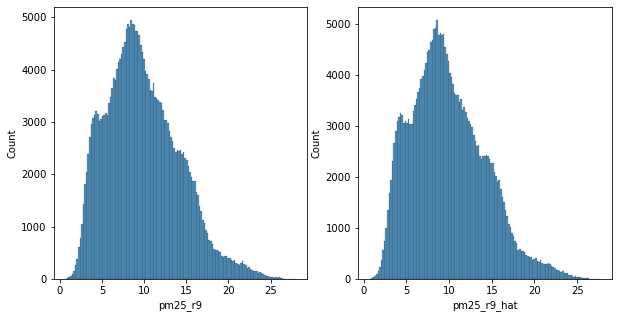

In [128]:
# fit one more model w/ best hyperparams
xgbr_s1_best = xgb.XGBRegressor(**best_params_s1, random_state=20)
xgbr_s1_best.fit(X_s1, y_s1)
y_hat = xgbr_s1_best.predict(X_s1)

# make sure its the same
rmse_val = np.mean(((y_s1 - y_hat)**2)**.5)
print(f"RMSE of the best Stage 1 Model: {rmse_val}")

df_model_s1[target_name_s1+"_hat"] = y_hat # generate predicted pm2.5

columns = [target_name_s1, target_name_s1+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sns.histplot(
            df_model_s1[columns[idx]],
            ax=ax
        )

# xgb stage 2


Making the df_model for Stage 2: `df_model_s2`

In [129]:
# Prepare dataset

print(f"Name of the target variable for Stage 2: {y_var_s2} \nIn df_model_s1 columns? {y_var_s2 in df_model_s1.columns}\n")

predictor_name_s2 = target_name_s1 + "_hat"

print(f"Name of the predictor variable for Stage 2: {predictor_name_s2} \nIn df_model_s1 columns? {predictor_name_s2 in df_model_s1.columns}\n")

# drop na's in columns of interes, sort by year_month and reset index
df_model_s2 = df_model_s1.dropna(subset=([y_var_s2, predictor_name_s2] + fixed_effects_cols))
df_model_s2 = df_model_s2.sort_values('year_month').reset_index(drop=True)

print(f"Size of 2nd stage df before filtering for modeling: {df_model_s1.shape}")
print(f"Size of 2nd stage df after filtering for modeling: {df_model_s2.shape}")

Name of the target variable for Stage 2: y_visits_hematopoietic_cancers_fwd3 
In df_model_s1 columns? True

Name of the predictor variable for Stage 2: pm25_r9_hat 
In df_model_s1 columns? True

Size of 2nd stage df before filtering for modeling: (262450, 203)
Size of 2nd stage df after filtering for modeling: (66151, 203)


In [130]:
# optional code to filter outliers

if filter_medical_outliers:
    print(f"Outcome: {y_var_s2}")
    display(df_model_s2[y_var_s2].describe())
    old_row_count = df_model_s2.shape[0]

    # df_model_s2 = df_model_s2[ np.abs(df_model_s2[y_var_s2]-df_model_s2[y_var_s2].mean()) <= min(3*df_model_s2[y_var_s2].std(), 1000*int(lag_time)) ]
    df_model_s2 = df_model_s2[ np.abs(df_model_s2[y_var_s2]-df_model_s2[y_var_s2].mean()) <= (3*df_model_s2[y_var_s2].std()) ]
    new_row_count = df_model_s2.shape[0]
    print(f"Outliers (over 3 std away) were filtered out, We drop {old_row_count - new_row_count} rows:")
    display(df_model_s2[y_var_s2].describe())

Outcome: y_visits_hematopoietic_cancers_fwd3


count    66151.000000
mean         1.686042
std          8.356586
min          0.000000
25%          0.000000
50%          0.000000
75%          1.676198
max        652.841782
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64

Outliers (over 3 std away) were filtered out, We drop 522 rows:


count    65629.000000
mean         1.171650
std          2.537956
min          0.000000
25%          0.000000
50%          0.000000
75%          1.631165
max         26.678929
Name: y_visits_hematopoietic_cancers_fwd3, dtype: float64

In [131]:
# split out X and y for stage 2 predictions
X_s2 = df_model_s2[[predictor_name_s2] + fixed_effects_cols]
y_s2 = df_model_s2[y_var_s2]

For reference: best XGB CV results for notebook 06:

- {'max_depth': 18, 'subsample': 0.8, 'eta': 0.01, 'n_estimators': 180, 'reg_lambda': 1.0}
- best RMSE test: 1.4724818369485975

In [132]:
# tune XGBoost for Stage 2
output_s2, best_params_s2 = time_series_cv(df_model_s2, 
  xvars = ([predictor_name_s2] + fixed_effects_cols), 
  yvar = y_var_s2, 
  hyperparams = {'max_depth': [18], 
                  'subsample': [.8, 1], 
                  'eta': [0.01, 0.03], 
                  'n_estimators': [180],
                  'reg_lambda': [0.01, 0.1, 1]}, 
  search_type = 'grid', 
  folds = 5, 
  verbose=1)

Working on fold 1/5
Working on fold 2/5
Working on fold 3/5
Working on fold 4/5
Working on fold 5/5
best hyperparams: {'max_depth': 18, 'subsample': 0.8, 'eta': 0.01, 'n_estimators': 180, 'reg_lambda': 1.0}
best RMSE test: 1.4734628738610154


Search space takes ~1hour on Anand's Laptop with 32gb Memory:

```
hyperparams = {'max_depth': [18], 
                  'subsample': [.8, 1], 
                  'eta': [0.01, 0.03], 
                  'n_estimators': [180],
                  'reg_lambda': [0.01, 0.1, 1]}
```

In [133]:
best_params_s2  # best hyperparams for stage 2

{'max_depth': 18,
 'subsample': 0.8,
 'eta': 0.01,
 'n_estimators': 180,
 'reg_lambda': 1.0}

In [134]:
# Tabulate CV results
output_s2_df = pd.DataFrame({
  'hyperparams': output_s2['hyperparams'],
  'fold': output_s2['fold'],
  'rmse_train': output_s2['rmse_train'],
  'rmse_test': output_s2['rmse_test'],
  'huber_loss_train': output_s2['huber_loss_train'],
  'huber_loss_test': output_s2['huber_loss_test']
})

output_s2_df['hyperparams'] = output_s2_df['hyperparams'].astype(str)

output_s2_grp = output_s2_df.groupby('hyperparams')[['rmse_train', 'rmse_test', \
'huber_loss_train', 'huber_loss_test']].mean().reset_index().sort_values('rmse_test')

pd.set_option('max_colwidth', None)
output_s2_grp[['hyperparams', 'rmse_test']].head(20)

,hyperparams,rmse_test
2,"{'max_depth': 18, 'subsample': 0.8, 'eta': 0.01, 'n_estimators': 180, 'reg_lambda': 1.0}",1.473463
8,"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.01, 'n_estimators': 180, 'reg_lambda': 1.0}",1.481654
7,"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.01, 'n_estimators': 180, 'reg_lambda': 0.1}",1.529338
1,"{'max_depth': 18, 'subsample': 0.8, 'eta': 0.01, 'n_estimators': 180, 'reg_lambda': 0.1}",1.536717
0,"{'max_depth': 18, 'subsample': 0.8, 'eta': 0.01, 'n_estimators': 180, 'reg_lambda': 0.01}",1.546070
6,"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.01, 'n_estimators': 180, 'reg_lambda': 0.01}",1.550271
5,"{'max_depth': 18, 'subsample': 0.8, 'eta': 0.03, 'n_estimators': 180, 'reg_lambda': 1.0}",1.580026
11,"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.03, 'n_estimators': 180, 'reg_lambda': 1.0}",1.581945
4,"{'max_depth': 18, 'subsample': 0.8, 'eta': 0.03, 'n_estimators': 180, 'reg_lambda': 0.1}",1.616229
10,"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.03, 'n_estimators': 180, 'reg_lambda': 0.1}",1.617973


Train final Stage 2 Model with Best Parameters

- Notebook 06 best results: Stage 2 RMSE = 0.7906362606392728

RMSE of the best Stage 2 Model: 0.7458193083278072


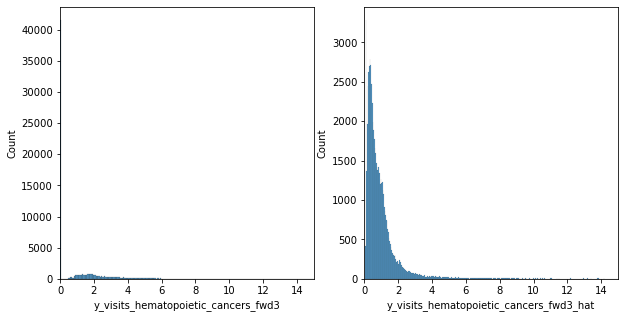

In [135]:
# Train the model using best stage 2's hyper parameters
# fit one more model w/ best hyperparams
xgbr_s2_best = xgb.XGBRegressor(**best_params_s2, random_state=20)
xgbr_s2_best.fit(X_s2, y_s2)
y_s2_hat = xgbr_s2_best.predict(X_s2)

# make sure its the same
rmse_val_s2 = np.mean(((y_s2 - y_s2_hat)**2)**.5)
print(f"RMSE of the best Stage 2 Model: {rmse_val_s2}")

# generate predicted health outcomes
df_model_s2[y_var_s2+"_hat"] = y_s2_hat

columns = [y_var_s2, y_var_s2+"_hat"]

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    ax.set_xlim(0, 15)
    sns.histplot(
            df_model_s2[columns[idx]],
            ax=ax
        )

## Counterfactual Generation: Make the 1%, 10%, 25% mitigation pm25_hat columns

Make these columns, run the s2 XGB on these columns to get their new HO predicted values

Save out csv with columns.

In [136]:
print(f"Rows originally: {df_model_s2.shape[0]}")

# we don't want to be predicting negative rates (our original y variable), but it is okay to predict negative differences
# filter out negative rates and see how many we dropped
if y_var_s2 not in y_col_names_lag_diff:
    print(f"Rows filtered out: {df_model_s2.shape[0] - df_model_s2[df_model_s2[y_var_s2 + '_hat'] >= 0].shape[0]}")

    df_model_s2 = df_model_s2[df_model_s2[y_var_s2 + '_hat'] >= 0]  # filter out the places we predict negative health outcome


Rows originally: 65629
Rows filtered out: 0


Creates the Counterfactual Differences Columns

- Each column gives the difference between the health outcome with X% reduction in predicted PM2.5 and with 0% reduction in predicted PM2.5.
- Each column begins with `'Difference_'` and ends with `'_X%_reduction'` where `X` is the percent we hypothetically reduce PM2.5.

In [137]:

# Make Column of 0.99*df_model_s2[predictor_name_s2]
reduced_pm25_col_name = predictor_name_s2 + "_1%_reduction"
df_model_s2[reduced_pm25_col_name] = 0.99 * df_model_s2[predictor_name_s2]
X_temp = df_model_s2[[reduced_pm25_col_name] + fixed_effects_cols]

 # XGBRegressor needs columns to be named the same as during predict, so rename our prediction column for Stage 2
X_temp.rename(columns={reduced_pm25_col_name: predictor_name_s2}, inplace=True)

# Predict Health Outcome for this column, add as column to df_model_s2
df_model_s2[y_var_s2 + "_hat" + "_1%_reduction"] = xgbr_s2_best.predict(X_temp)
df_model_s2["Difference_" + y_var_s2 + "_hat" + "_1%_reduction"] = df_model_s2[y_var_s2 + "_hat" + "_1%_reduction"] - df_model_s2[y_var_s2 + "_hat"]


# Make Column of 0.90*df_model_s2[predictor_name_s2]
reduced_pm25_col_name = predictor_name_s2 + "_10%_reduction"
df_model_s2[reduced_pm25_col_name] = 0.90 * df_model_s2[predictor_name_s2]
X_temp = df_model_s2[[reduced_pm25_col_name] + fixed_effects_cols]
X_temp.rename(columns={reduced_pm25_col_name: predictor_name_s2}, inplace=True)


# Predict Health Outcome for this column, add as column to df_model_s2
df_model_s2[y_var_s2 + "_hat" + "_10%_reduction"] = xgbr_s2_best.predict(X_temp)
df_model_s2["Difference_" + y_var_s2 + "_hat" + "_10%_reduction"] = df_model_s2[y_var_s2 + "_hat" + "_10%_reduction"] - df_model_s2[y_var_s2 + "_hat"]


# Make Column of 0.75*df_model_s2[predictor_name_s2]
reduced_pm25_col_name = predictor_name_s2 + "_25%_reduction"
df_model_s2[reduced_pm25_col_name] = 0.75 * df_model_s2[predictor_name_s2]
X_temp = df_model_s2[[reduced_pm25_col_name] + fixed_effects_cols]
X_temp.rename(columns={reduced_pm25_col_name: predictor_name_s2}, inplace=True)


# Predict Health Outcome for this column, add as column to df_model_s2
df_model_s2[y_var_s2 + "_hat" + "_25%_reduction"] = xgbr_s2_best.predict(X_temp)
df_model_s2["Difference_" + y_var_s2 + "_hat" + "_25%_reduction"] = df_model_s2[y_var_s2 + "_hat" + "_25%_reduction"] - df_model_s2[y_var_s2 + "_hat"]


Adding fixed versions of difference columns to make the counterfactual map legend color bars less weird.

- Fixed versions keep the data to plot that only has mitigation showing no reduction or some reduction in health outcome.
- All have suffix of `'_fixed'` ad the end.

In [138]:
df_model_s2["Difference_" + y_var_s2 + "_hat" + "_1%_reduction_fixed"] = df_model_s2["Difference_" + y_var_s2 + "_hat" + "_1%_reduction"] \
                                                                    .mask(
                                                                       df_model_s2["Difference_" + y_var_s2 + "_hat" + "_1%_reduction"] > 0, 0 
                                                                    )


df_model_s2["Difference_" + y_var_s2 + "_hat" + "_10%_reduction_fixed"] = df_model_s2["Difference_" + y_var_s2 + "_hat" + "_10%_reduction"] \
                                                                    .mask(
                                                                       df_model_s2["Difference_" + y_var_s2 + "_hat" + "_10%_reduction"] > 0, 0 
                                                                    )

df_model_s2["Difference_" + y_var_s2 + "_hat" + "_25%_reduction_fixed"] = df_model_s2["Difference_" + y_var_s2 + "_hat" + "_25%_reduction"] \
                                                                    .mask(
                                                                       df_model_s2["Difference_" + y_var_s2 + "_hat" + "_25%_reduction"] > 0, 0 
                                                                    )

In [139]:
# List the columns added for Counterfactual Analysis
cols_added_counterfactual = [i for i in df_model_s2.columns if "Difference_" in i]

print(f"Columns added for the counterfactual analysis: {cols_added_counterfactual}")

Columns added for the counterfactual analysis: ['Difference_y_visits_hematopoietic_cancers_fwd3_hat_1%_reduction', 'Difference_y_visits_hematopoietic_cancers_fwd3_hat_10%_reduction', 'Difference_y_visits_hematopoietic_cancers_fwd3_hat_25%_reduction', 'Difference_y_visits_hematopoietic_cancers_fwd3_hat_1%_reduction_fixed', 'Difference_y_visits_hematopoietic_cancers_fwd3_hat_10%_reduction_fixed', 'Difference_y_visits_hematopoietic_cancers_fwd3_hat_25%_reduction_fixed']


In [140]:
# check out the relevant columns needed for the counterfactual plot
counter_fact_columns = ['year_month', 'school_zip'] + [i for i in df_model_s2.columns if predictor_name_s2 in i] + cols_added_counterfactual
df_model_s2[counter_fact_columns].head(10)

,year_month,school_zip,pm25_r9_hat,pm25_r9_hat_1%_reduction,pm25_r9_hat_10%_reduction,pm25_r9_hat_25%_reduction,Difference_y_visits_hematopoietic_cancers_fwd3_hat_1%_reduction,Difference_y_visits_hematopoietic_cancers_fwd3_hat_10%_reduction,Difference_y_visits_hematopoietic_cancers_fwd3_hat_25%_reduction,Difference_y_visits_hematopoietic_cancers_fwd3_hat_1%_reduction_fixed,Difference_y_visits_hematopoietic_cancers_fwd3_hat_10%_reduction_fixed,Difference_y_visits_hematopoietic_cancers_fwd3_hat_25%_reduction_fixed
0,2002-01-01,95135,13.295642,13.162685,11.966078,9.971731,-0.021071,-2.123114,-3.077256,-0.021071,-2.123114,-3.077256
31,2002-01-01,92627,23.765083,23.527433,21.388575,17.823812,-0.118733,-0.131410,-0.134402,-0.118733,-0.131410,-0.134402
30,2002-01-01,92253,16.195240,16.033287,14.575716,12.146430,-5.146262,-5.146803,-5.145607,-5.146262,-5.146803,-5.145607
29,2002-01-01,92129,14.117611,13.976435,12.705850,10.588208,0.007827,0.003481,0.002829,0.000000,0.000000,0.000000
28,2002-01-01,92283,16.278454,16.115669,14.650608,12.208840,4.156471,0.981642,0.854375,0.000000,0.000000,0.000000
27,2002-01-01,95355,16.367800,16.204123,14.731019,12.275850,-1.467621,-1.467298,-1.459092,-1.467621,-1.467298,-1.459092
26,2002-01-01,95453,13.098177,12.967196,11.788359,9.823633,5.478715,4.281131,3.360262,0.000000,0.000000,0.000000
25,2002-01-01,95817,15.515343,15.360189,13.963808,11.636507,0.239082,0.747203,0.789128,0.000000,0.000000,0.000000
23,2002-01-01,95667,13.011863,12.881744,11.710676,9.758897,1.463798,1.524267,1.262121,0.000000,0.000000,0.000000
22,2002-01-01,94531,13.607932,13.471853,12.247139,10.205949,0.012336,-0.006360,0.030815,0.000000,-0.006360,0.000000


In [141]:
# summary statistics on our counterfactual column
df_model_s2[cols_added_counterfactual].describe()

,Difference_y_visits_hematopoietic_cancers_fwd3_hat_1%_reduction,Difference_y_visits_hematopoietic_cancers_fwd3_hat_10%_reduction,Difference_y_visits_hematopoietic_cancers_fwd3_hat_25%_reduction,Difference_y_visits_hematopoietic_cancers_fwd3_hat_1%_reduction_fixed,Difference_y_visits_hematopoietic_cancers_fwd3_hat_10%_reduction_fixed,Difference_y_visits_hematopoietic_cancers_fwd3_hat_25%_reduction_fixed
count,65629.000000,65629.000000,65629.000000,65629.000000,65629.000000,65629.000000
mean,-0.000775,-0.000444,-0.001538,-0.520255,-0.514359,-0.508405
std,2.114460,2.080811,2.040792,1.408447,1.406928,1.405485
min,-21.328979,-21.328979,-21.322750,-21.328979,-21.328979,-21.322750
25%,-0.503697,-0.490647,-0.478109,-0.503697,-0.490647,-0.478109
50%,0.001606,0.014526,0.031151,0.000000,0.000000,0.000000
75%,0.507896,0.517794,0.526099,0.000000,0.000000,0.000000
max,21.255951,21.366657,20.942244,0.000000,0.000000,0.000000


In [142]:
# number of rows total
df_model_s2.shape

(65629, 216)

In [143]:
# number of rows where 1% reduction reduced health outcome
df_model_s2[df_model_s2[y_var_s2 + '_hat'] > df_model_s2[y_var_s2 + '_hat_1%_reduction']].shape

(32693, 216)

In [144]:
# number of rows where 10% reduction reduced health outcome
df_model_s2[df_model_s2[y_var_s2 + '_hat'] > df_model_s2[y_var_s2 + '_hat_10%_reduction']].shape

(32066, 216)

In [145]:
# number of rows where 25% reduction reduced health outcome
df_model_s2[df_model_s2[y_var_s2 + '_hat'] > df_model_s2[y_var_s2 + '_hat_25%_reduction']].shape

(31404, 216)

In [146]:
# Take a look at the top 50 counties where 25% reduction in pollution reduced health outcomes, by frequency.
df_model_s2[df_model_s2[y_var_s2 + '_hat'] > df_model_s2[y_var_s2 + '_hat_25%_reduction']]['school_zip'].value_counts().head(50)

92283    180
95817    153
92121    151
93652    149
94114    147
93266    141
93256    139
95713    139
95922    135
94132    133
92253    125
95461    125
91978    120
93286    120
95457    119
92651    119
92567    114
92672    114
94619    113
93268    112
92612    111
95917    111
95914    111
95641    110
92129    110
95476    109
94514    108
94949    108
91361    108
95829    107
94564    106
94561    106
91765    106
92591    106
95638    106
93428    105
93665    104
93312    104
91766    104
95684    104
93543    104
91775    103
95695    103
92124    101
95963    101
93925    101
91768    100
94954    100
95337    100
92376    100
Name: school_zip, dtype: int64

Saving Stage 2 csv: 

In [147]:
counterfactual_csv_name = notebook_index + "_XGB_s2_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + y_var_s2

print(counterfactual_csv_name)

16_XGB_s2_INSTRUMENT_Izmy_v4_nodist_normed_TPY_r9_FE_SET_7_TARGETING_y_visits_hematopoietic_cancers_fwd3


In [148]:
# dropping health data before saving csv
df_model_s2.drop(columns=(num_visits_col_names + y_col_names), inplace=True)  
df_model_s2.to_csv(os.path.join(out_dir_xgb, counterfactual_csv_name + ".csv"))

### Save XGBoost Models
- save as `.txt`

Stage 1

In [149]:
stage1_model_name = notebook_index + "_XGB_MODEL_s1_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + y_var_s2
stage1_model_name

'16_XGB_MODEL_s1_INSTRUMENT_Izmy_v4_nodist_normed_TPY_r9_FE_SET_7_TARGETING_y_visits_hematopoietic_cancers_fwd3'

In [150]:
xgbr_s1_best.save_model(os.path.join(out_dir_xgb, stage1_model_name+ ".txt"))

In [151]:
# load it back in to see if it works!
models1_loaded = xgb.XGBRegressor()
models1_loaded.load_model(os.path.join(out_dir_xgb, stage1_model_name+ ".txt"))
print(models1_loaded.best_ntree_limit)

models1_loaded.predict(X_s1)

180


array([21.942682 , 22.881857 , 23.642935 , ...,  3.2541504,  3.451995 ,
        3.5449603], dtype=float32)

Stage 2

In [152]:
stage2_model_name = notebook_index + "_XGB_MODEL_s2_INSTRUMENT_" + predictor_name_s1 + "_FE_SET_" + str(FE_set_num) + "_TARGETING_" + y_var_s2
stage2_model_name

'16_XGB_MODEL_s2_INSTRUMENT_Izmy_v4_nodist_normed_TPY_r9_FE_SET_7_TARGETING_y_visits_hematopoietic_cancers_fwd3'

In [153]:
xgbr_s2_best.save_model(os.path.join(out_dir_xgb, stage2_model_name+ ".txt"))

In [154]:
# load it back in to see if it works!
models2_loaded = xgb.XGBRegressor()
models2_loaded.load_model(os.path.join(out_dir_xgb, stage2_model_name+ ".txt"))
print(models2_loaded.best_ntree_limit)

models2_loaded.predict(X_s2)

180


array([4.951865  , 0.33574244, 5.25613   , ..., 0.6033494 , 1.5481743 ,
       0.62524873], dtype=float32)